In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pylab as plt 
from scipy.stats import norm
import yfinance as yf 
from itertools import accumulate

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def strategy_evaluation(result, data_names, freq = 'D'):

    
    port = pd.DataFrame(result)
    port_ret = calc_port_ret(port)
    benchmark = port_ret['Benchmark']
    
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D', benchmark = benchmark).transpose()], 
                               axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M',
                                                    benchmark = benchmark).transpose()], axis = 0)
        metrics.index = data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino', 'IR'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'Active Risk'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.1%}", 'Volatility': "{:.1%}",'Active Risk': "{:.1%}",
              'Sharpe': "{:.1f}",'MAR': "{:.2f}", 'Sortino': "{:.1f}",'IR': "{:.2f}" })
      .set_table_styles(styles)
      .set_properties(**{'color': 'black'}))
    
    return metrics


def port_eval(port, freq = 'D', benchmark = None):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    

    rel_return = port_ret.subtract(benchmark, axis = 0) +1

    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(252),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(252/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        

    
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(12),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(12/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                float(active_risk.iloc[0]),float(IR.iloc[0])]},
                  index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'Active Risk',
                         'IR'])
                           
                  #index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    metrics[metrics.isna()] = 0
    
    return metrics 




def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [3]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles)
          .set_properties(**{'color': 'black'}))
    
    return corr

## Momentum Backtest

To do

- Add rebalancing Spread
- Add volatility weighting (Naive)


In [4]:
price_df = pd.read_csv('data/VQ_data.csv')
price_df['d'] = pd.to_datetime(price_df['d'])
price_df = price_df.set_index(['d', 'insID'])

In [5]:
index_df = pd.read_csv('data/OMX_GI.csv')
index_df['d'] = pd.to_datetime(index_df['d'])
index_df = index_df.set_index(['d'])
index_df = pd.DataFrame(index_df['c'])
index_df = index_df.resample('m').last()
index_df = index_df.pct_change()
index_df = index_df.shift(-1)

In [6]:
# USE ONLY DATA WHERE WE HAVE EA RET
close_df = price_df.loc[price_df['PE'].first_valid_index():,]
close_df =close_df.groupby([close_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
data_df = close_df.swaplevel()

# get return, use adjusted price for dividends
data_df['ret'] = data_df['adj_c'].groupby(level='insID').pct_change(1).shift(-1)


In [52]:
ml_pred_df = pd.read_csv('stat_analysis/RF_pred.csv')
ml_pred_df['d'] = pd.to_datetime(ml_pred_df['d'])
ml_pred_df = ml_pred_df.set_index(['d', 'insID'])

data_df = data_df.join(ml_pred_df, on=['d','insID'],how='left')
data_df['RF_pred'] = data_df['RF_pred'].groupby(level='insID').ffill()

ValueError: columns overlap but no suffix specified: Index(['RF_pred'], dtype='object')

In [53]:
data_df['market'].unique()

array(['Large_Cap', 'Small_Cap', 'Mid_Cap', 'First_North'], dtype=object)

### SETTINGS FOR BACKTEST

In [54]:
min_MCAP = 500
min_liq = 0.5
not_secors = ['finance_RE'] #'finance_RE'
not_markets = [None]

data_df=data_df[ ~data_df['sector'].isin(not_secors)]
data_df=data_df[ ~data_df['market'].isin(not_markets)]
data_df = data_df[data_df['MCAP']>min_MCAP]
#data_df = data_df[data_df['MA50_VOL']>min_liq]

### RANKS

In [55]:
### Momentum Ranks

### ALPHA & BETA

data_df['alpha_rank'] = data_df['alpha'].groupby(level='d').rank(ascending=False)
data_df['low_beta_rank'] = data_df['beta'].groupby(level='d').rank(ascending=True)
data_df['sharpe_rank'] = data_df['sharpe'].groupby(level='d').rank(ascending=False)
data_df['res_mom12_rank'] = data_df['res_mom12'].groupby(level='d').rank(ascending=False)
data_df['ido_mom12_rank'] = data_df['ido_mom12'].groupby(level='d').rank(ascending=False)

data_df['std_alpha_rank'] = data_df['std_alpha'].groupby(level='d').rank(ascending=False)


#rank based on 12 month mom
data_df['mom12_rank'] = data_df['mom12'].groupby(level='d').rank(ascending=False)
data_df['mom6_rank'] = data_df['mom6'].groupby(level='d').rank(ascending=False)
data_df['mom3_rank'] = data_df['mom3'].groupby(level='d').rank(ascending=False)
data_df['mom1_rank'] = data_df['mom1'].groupby(level='d').rank(ascending=False)


data_df['3y_high_rank'] = data_df['high_3y'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['2y_high_rank'] = data_df['high_2y'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['12m_high_rank'] = data_df['high_12m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['6m_high_rank'] = data_df['high_6m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['3m_high_rank'] = data_df['high_3m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['1m_high_rank'] = data_df['high_1m'].groupby(level='d').rank(ascending=False, method = 'first')




data_df['ST_rev_rank'] = data_df['mom1'].groupby(level='d').rank(ascending=True)

data_df['adj_mom_rank'] = data_df['adj_mom'].groupby(level='d').rank(ascending=False)
data_df['EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=False)
data_df['EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=False)
data_df['accel_rank'] = data_df['acceleration'].groupby(level='d').rank(ascending=False)
data_df['volatility_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=True)
data_df['RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=False)
data_df['SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=False)
data_df['EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=False)
data_df['rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=False)
data_df['EPS_a_rank'] = data_df['EPS_acceleration'].groupby(level='d').rank(ascending=False)



### COMPOSITE RANKS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(comb_mom = x.mom12_rank + x.mom6_rank +x.mom3_rank)) #x.mom12_rank + x.mom6_rank +x.mom3_rank +

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_MOM = x.comb_mom +x.EAR_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_std_MOM = x.comb_mom +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod1_comb_mom = x.mom12_rank +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod2_comb_mom = x.mom12_rank + x.mom6_rank  +x.EAR_std_rank ))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod3_comb_mom = x.mom12_rank + x.mom6_rank  +x.EAR_std_rank +x.res_mom12_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(focus_mom = x.EAR_std_rank + x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mom_vol = x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(fund_mom = x.SUE_rank + x.RSURP_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_SUE = x.SUE_rank +x.EAR_std_rank ))



data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EMA = x['12m_high_rank'] +x.EAR_std_rank + x.mom12_rank ))

data_df['comb_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mom_vol_rank'] = data_df['mom_vol'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['EAR_SUE_rank'] = data_df['EAR_SUE'].groupby(level='d').rank(ascending=True)  #should be True


data_df['mod1_comb_mom_rank'] = data_df['mod1_comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod2_comb_mom_rank'] = data_df['mod2_comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod3_comb_mom_rank'] = data_df['mod3_comb_mom'].groupby(level='d').rank(ascending=True)  #should be True






data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom = x.fund_mom_rank + x.ear_mom_rank))
data_df['twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom_alt = x.fund_mom_rank + x.comb_mom_rank +x.EAR_std_rank ))
data_df['twin_mom_alt_rank'] = data_df['twin_mom_alt'].groupby(level='d').rank(ascending=True)  #should be True





In [56]:
##VALUATION MEASURES

#### SET NEGATIVE MULTIPLES TO MAX, MAKES NO SENSE OTHERWISE

for ratio in ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']:
    data_df.loc[data_df[ratio]< 0,ratio] = data_df[ratio].max()



data_df['ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=True)
data_df['PE_rank'] = data_df['PE'].groupby(level='d').rank(ascending=True) #low is good
data_df['PB_rank'] = data_df['PB'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVEBIT_rank'] = data_df['EVEBIT'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVFCF_rank'] = data_df['EVFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['PS_rank'] = data_df['PS'].groupby(level='d').rank(ascending=True) #low is good
data_df['PFCF_rank'] = data_df['PFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['DIVY_rank'] = data_df['DIV_Y'].groupby(level='d').rank(ascending=False) #high is good
data_df['PO_rank'] = data_df['PO'].groupby(level='d').rank(ascending=False) #high is good
data_df['FY_rank'] = data_df['FY'].groupby(level='d').rank(ascending=True) #high is good
data_df['SY_rank'] = data_df['SY'].groupby(level='d').rank(ascending=True) #high is good





#### VALUE COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.PFCF_rank ))

data_df['VC_rank'] = data_df['VC'].groupby(level='d').rank(ascending=True)  #should be True


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC2 = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.ag_rank))

data_df['VC2_rank'] = data_df['VC2'].groupby(level='d').rank(ascending=True)  #should be True


In [57]:
### PROFITABILITY MEASURES
data_df['GPA_rank'] = data_df['GPA'].groupby(level='d').rank(ascending=False) #high is good
data_df['GPA_chg_rank'] = data_df['GPA_chg'].groupby(level='d').rank(ascending=False) #high is good

data_df['ROIC_rank'] = data_df['ROIC'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_rank'] = data_df['ROE'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_chg_rank'] = data_df['ROE_chg'].groupby(level='d').rank(ascending=False) #high is good
data_df['AT_rank'] = data_df['AT'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROA_rank'] = data_df['ROA'].groupby(level='d').rank(ascending=False) #high is good
data_df['FCFROE_rank'] = data_df['FCFROE'].groupby(level='d').rank(ascending=False) #high is good
data_df['Gross_margin_rank'] = data_df['Gross_margin'].groupby(level='d').rank(ascending=False) #high is good



#### QUALITY COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QC = x.GPA_rank + x.ROIC_rank + x.ROE_rank + x.AT_rank + x.FCFROE_rank))

data_df['QC_rank'] = data_df['QC'].groupby(level='d').rank(ascending=True)  #should be True



In [58]:
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VQ = x.VC_rank + x.QC_rank ))#VQ
data_df['VQ_rank'] = data_df['VQ'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QM = x.GPA_rank + x.ear_std_mom_rank ))#VQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod_QM = x.GPA_rank + x.ear_std_mom_rank + x.SUE_rank))#VQ




### COMPOSITE of COMPOSITE METRCIS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VM = x.VC2_rank + x.ear_std_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VMQ = x.VC2_rank + x.QC_rank + x.ear_std_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(zhang = x.ag_rank + x.GPA_rank))#VMQ

#### optimized

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VMQ_opt = 0.25*x.VC_rank + 0.25*x.QC_rank + 0.5*x.ear_std_mom_rank))#VMQ


data_df['VMQ_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=True)  #should be True
data_df['VMQ_opt_rank'] = data_df['VMQ_opt'].groupby(level='d').rank(ascending=True)  #should be True
data_df['VM_rank'] = data_df['VM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod_QM_rank'] = data_df['mod_QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=True)  #should be True

In [59]:
### ANTI STRATEGIES
data_df['neg_ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=False)

data_df['bad_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['dog_shit_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=True)
data_df['evil_twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=False)  #should be True

data_df['bad_ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=False)  #should be True

data_df['bad_VM_rank'] = data_df['VM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=False)  #should be True
########

data_df['2y_low_rank'] = data_df['low_2y'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['12m_low_rank'] = data_df['low_12m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['6m_low_rank'] = data_df['low_6m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['3m_low_rank'] = data_df['low_3m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['1m_low_rank'] = data_df['low_1m'].groupby(level='d').rank(ascending=True, method = 'first')


#Broken highs

data_df['2y_broken_high_rank'] = data_df['high_2y'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['12m_broken_high_rank'] = data_df['high_12m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['6m_broken_high_rank'] = data_df['high_6m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['3m_broken_high_rank'] = data_df['high_3m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['1m_broken_high_rank'] = data_df['high_1m'].groupby(level='d').rank(ascending=True, method = 'first')



#################
data_df['bad_QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['high_vol_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=False)
data_df['bad_QC_rank'] = data_df['QC'].groupby(level='d').rank(ascending=False)  #should be True

data_df['bad_VC_rank'] = data_df['VC'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_PE_rank'] = data_df['PE'].groupby(level='d').rank(ascending=False) #low is good
data_df['bad_ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=False)
data_df['bad_PB_rank'] = data_df['PB'].groupby(level='d').rank(ascending=False) #low is good

#########
data_df['low_alpha_rank'] = data_df['alpha'].groupby(level='d').rank(ascending=True)
data_df['high_beta_rank'] = data_df['beta'].groupby(level='d').rank(ascending=False)
data_df['low_sharpe_rank'] = data_df['sharpe'].groupby(level='d').rank(ascending=True)
data_df['low_res_mom12_rank'] = data_df['res_mom12'].groupby(level='d').rank(ascending=True)


data_df['low_mom12_rank'] = data_df['mom12'].groupby(level='d').rank(ascending=True)


In [60]:
### MISC STRATEGIES
#data_df['MEME_rank'] = data_df['MEME_factor'].groupby(level='d').rank(ascending=False)
#data_df['anti_MEME_rank'] = data_df['MEME_factor'].groupby(level='d').rank(ascending=True)

### ML STRATEGY
data_df['ML_rank'] = data_df['RF_pred'].groupby(level='d').rank(ascending=False, method = 'first').dropna()  #should be True
data_df['alt_ML_rank'] = data_df['RF_pred'].groupby(level='d').rank(ascending=True, method = 'first').dropna()  #should be True


### Set up back test

- equal weight
- no capital filter
- for loop for different ranks

In [61]:
value_strats_list = ['ag_rank', 'PE_rank','PB_rank','EVEBIT_rank', 'EVFCF_rank', 'PS_rank', 
               'PFCF_rank','DIVY_rank','FY_rank','VC_rank', 'VC2_rank']

quality_strats_list = ['Gross_margin_rank','GPA_rank', 'ROIC_rank', 'ROE_rank', 'AT_rank', 'ROA_rank', 'FCFROE_rank', 'QC_rank']

composite_strats_list = ['QC_rank', 'VC2_rank', 'ear_std_mom_rank', 'VM_rank', 'QM_rank','VQ_rank', 'VMQ_rank', 'twin_mom_rank', 'mod_QM_rank']

momentum_strats_list = ['res_mom12_rank','sharpe_rank','EAR_std_rank', 'mom12_rank', 
                       '12m_high_rank', '3y_high_rank', 'alpha_rank']

bad_momentum_list = ['bad_EMA_rank','low_sharpe_rank', 'low_res_mom12_rank',
                     'low_mom12_rank','bad_EAR_std_rank','2y_low_rank' ]


momentum_comp_list = ['comb_mom_rank', 'ear_std_mom_rank', 'mod3_comb_mom_rank']

misc_strats = ['SUE_rank', 'RSURP_rank', 'fund_mom_rank', 'twin_mom_rank', 'twin_mom_alt_rank', 'EAR_SUE_rank']


mom_ls_strats = ['ear_std_mom_rank', 'comb_mom_rank', 'bad_EAR_std_rank', 'neg_mom_rank', 'bad_mom_rank', 'EAR_std_rank']


alt_mom_list = ['alpha_rank','std_alpha_rank','low_beta_rank', 'high_beta_rank',
                'sharpe_rank','res_mom12_rank', 'EAR_std_rank','mom12_rank','FY_rank'  ]



bad_strats = ['bad_QM_rank', 'bad_mom_rank','dog_shit_rank', 'low_sharpe_rank' ]

fund_mom = ['SUE_rank', 'RSURP_rank', 'EPS_g_rank', 'rev_g_rank', 'EPS_a_rank']



################

best_strats = ['SUE_rank', 'VMQ_rank', 'ear_std_mom_rank', 'QM_rank', 'focus_mom_rank']

high_low_strats = ['12m_low_rank', '6m_low_rank', '12m_high_rank', '6m_high_rank', '3m_low_rank', '3m_high_rank']

highs = ['2y_high_rank','12m_high_rank', '6m_high_rank', '3m_high_rank', '1m_high_rank' ]

broken_highs = ['2y_broken_high_rank','12m_broken_high_rank',
                '6m_broken_high_rank', '3m_broken_high_rank', '1m_broken_high_rank' ]

lows = ['2y_low_rank','12m_low_rank', '6m_low_rank', '3m_low_rank', '1m_low_rank' ]
vol_strats = ['high_vol_rank', 'volatility_rank']

ml_strats = ['ML_rank', 'alt_ML_rank']


In [62]:
top_n = 20
rebal_period = 1

strat_df = pd.DataFrame()
strats_test =ml_strats

for strat in strats_test:
    
    rank_tmp = data_df.unstack(level = 'insID')[strat]
    rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
    ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
    
    rank_df_empt= rank_tmp.copy()
    rank_df_empt[:] = np.nan
    for col in rank_tmp.columns:
        rank_df_empt.loc[::rebal_period,col] = np.where(rank_tmp[::rebal_period][col]<=top_n, 1, 0)
    
    filled_rank_df = rank_df_empt.fillna(method="ffill")
    
    ret_tmp=np.multiply(filled_rank_df,ret_df)
    ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
    ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
    ret_neu_tmp.columns = [strat]

    strat_df = pd.concat([strat_df, ret_neu_tmp],axis = 1, sort=False)

In [63]:
def vol_weighting(data):
    sum_vol = 0
    for i in data.index:
        if data[i] > 0:
            sum_vol = sum_vol + (1/data[i])
    
    
    weight = []
    for i in data.index:
        if data[i] > 0:
            w = (1/data[i])/(sum_vol)
        else:
            w = 0
        weight.append(w)
    
    return(weight)

In [64]:
# # vol weight test
# vol_tmp = data_df.unstack(level = 'insID')['volatility']
# vol_tmp = vol_tmp.loc[filled_rank_df.index,filled_rank_df.columns]


# vol_df = np.multiply(filled_rank_df,vol_tmp)
# vol_df = np.multiply(filled_rank_df,vol_tmp)
# vol_weights = vol_df.apply(vol_weighting, axis = 1, result_type='expand')
# vol_weights.columns = vol_df.columns

# vol_ret_tmp=np.multiply(vol_weights,ret_df)
# vol_ret=vol_ret_tmp.sum(axis =1)
# vol_ret = pd.DataFrame(vol_ret)
# vol_ret.columns = [strat + '_volW']
# strat_df = pd.concat([strat_df, vol_ret],axis = 1, sort=False)

In [65]:
strat_df = strat_df.dropna()
result = pd.concat([strat_df, index_df],axis = 1, sort=False)
result.columns = strat_df.columns.to_list() + ["Benchmark"]
result = result.dropna()
result = result[:-1]

In [66]:
def long_short(long_leg, short_leg, vol = 0.15):
    
    vol_long = long_leg.std()*np.sqrt(12)
    vol_short = short_leg.std()*np.sqrt(12)
    
    w_sum = (1/vol_long) + (1/vol_short)
    w_long = (1/vol_long )/w_sum
    w_short = (1/vol_short )/w_sum
    un_lev = w_long*long_leg - w_short*short_leg
    lev_faktor = vol/(un_lev.std()*np.sqrt(12)) #(vol/un_lev.std()*np.sqrt(12))
    strat =  lev_faktor * un_lev
    return(strat)

In [67]:
#result['LS_VOL'] = long_short(long_leg =result['volatility_rank'], short_leg = result['high_vol_rank'] )
#result['LS_QUAL'] = long_short(long_leg =result['QC_rank'], short_leg = result['bad_QC_rank'] )
#result['LS_MOM'] = long_short(long_leg =result['comb_mom_rank'], short_leg = result['neg_mom_rank'] )
#result['LS_VMQ'] = long_short(long_leg =result['VMQ_rank'], short_leg = result['dog_shit_rank'] )
#result['LS_qm'] = long_short(long_leg =result['QM_rank'], short_leg = result['bad_QM_rank'] )
#result['LS_EAR_MOM'] = long_short(long_leg =result['ear_std_mom_rank'], short_leg = result['bad_mom_rank'] )
#result['LS_SY'] = long_short(long_leg =result['ear_std_mom_rank'], short_leg = result['bad_mom_rank'] )

result['LS_ML'] = long_short(long_leg =result['ML_rank'], short_leg = result['alt_ML_rank'] )






In [68]:
#result = result[['LS_VOL','LS_EAR_MOM', 'LS_VMQ','LS_MOM','Benchmark' ]]

In [69]:
result_cum = result+1
result_cum = result_cum.cumprod()
result_cum = result_cum.astype('float64')

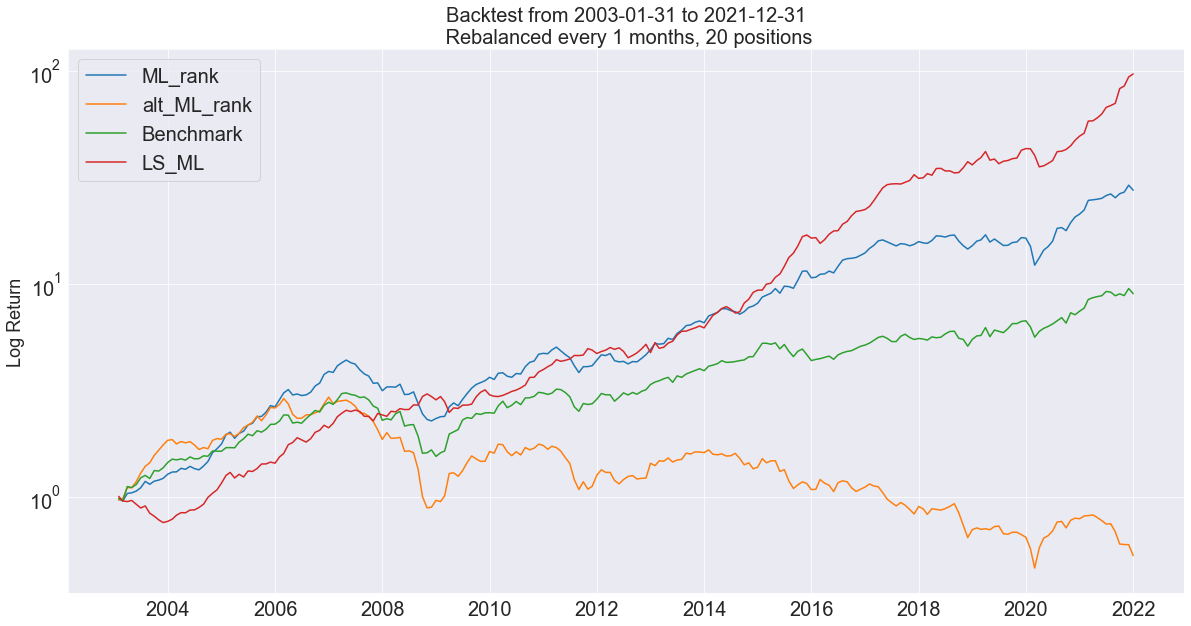

In [70]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result_cum.columns:
    plt.plot(result_cum[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end) +
          "\n Rebalanced every " + str(rebal_period) + " months, " + str(top_n) + " positions", fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

In [71]:
strategy_evaluation(result_cum, result_cum.columns, freq = 'M')

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,Active Risk,IR
ML_rank,19.2%,16.0%,1.2,1.6,-48.0%,0.40,10.8%,0.51
alt_ML_rank,-3.1%,22.9%,-0.1,-0.2,-84.0%,0.04,15.4%,-0.90
Benchmark,12.4%,16.3%,0.8,0.9,-50.0%,0.25,0.0%,0.00
LS_ML,27.2%,14.8%,1.8,2.7,-25.0%,1.09,21.9%,0.48


In [74]:
correlation_map(result_cum)


,ML_rank,alt_ML_rank,Benchmark,LS_ML
ML_rank,1.00,0.75,0.78,0.35
alt_ML_rank,0.75,1.00,0.74,-0.35
Benchmark,0.78,0.74,1.00,0.06
LS_ML,0.35,-0.35,0.06,1.00


In [75]:
result_by_year = (result+1).groupby(result.index.year).prod() - 1
result_by_month = (result+1).groupby(result.index.month).mean() - 1
result_by_year

,ML_rank,alt_ML_rank,Benchmark,LS_ML
d,,,,
2003,0.282046,0.848912,0.454865,-0.230019
2004,0.384886,0.012195,0.129076,0.510851
2005,0.495647,0.401085,0.339885,0.241224
2006,0.465427,0.124737,0.267139,0.465916
2007,-0.188299,-0.367094,-0.177036,0.149595
2008,-0.258934,-0.482626,-0.322967,0.176460
2009,0.560752,0.695971,0.603420,0.055350
2010,0.295076,0.067701,0.237346,0.313543
2011,-0.070972,-0.275086,-0.065749,0.190081


## Performance by rebalancing date

- measure by sharpe ratio

In [76]:
rebal_diff_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))
turnover_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))


for strat in strats_test:
    
    for rebal in rebal_diff_df.columns:
    
        rank_tmp = data_df.unstack(level = 'insID')[strat]
        rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
        ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
 
        sharpe_list = []    
        rank_df_empt= rank_tmp.copy()
        rank_df_empt[:] = np.nan
        for col in rank_tmp.columns:
            rank_df_empt.loc[::rebal,col] = np.where(rank_tmp[::rebal][col]<=top_n, 1, 0)
    
        filled_rank_df = rank_df_empt.fillna(method="ffill")
    
        ret_tmp=np.multiply(filled_rank_df,ret_df)
        ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
        ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
        ret_neu_tmp.columns = [strat]
        sharpe_tmp = (ret_neu_tmp.mean()*12)/(ret_neu_tmp.std()*np.sqrt(12))
        turnover = filled_rank_df.diff().abs().sum().sum()
        years = len(rank_df_empt)/12
        turn_year = (turnover/top_n)/years
        
        
        turnover_df.loc[strat,rebal] = turn_year/2
        rebal_diff_df.loc[strat,rebal] = sharpe_tmp[0]
        

In [77]:
rebal_diff_df

,1,2,3,4,5,6,7,8,9,10,11,12
ML_rank,1.179935,1.105548,1.062799,1.137194,1.122466,1.016944,1.009844,1.147982,1.12416,1.204014,1.094091,1.05944
alt_ML_rank,-0.025081,0.037512,0.13626,0.177567,0.221237,0.25045,0.283824,0.355867,0.2378,0.187329,0.221824,0.499874


In [78]:
turnover_df

,1,2,3,4,5,6,7,8,9,10,11,12
ML_rank,4.192174,2.462609,1.818261,1.541739,1.314783,1.106087,1.017391,0.936522,0.782609,0.730435,0.688696,0.678261
alt_ML_rank,4.085217,2.64,2.00087,1.646087,1.366957,1.202609,1.074783,0.973043,0.829565,0.78,0.735652,0.69913


In [79]:
## Get current top N of different ranks
current_port_df = data_df.copy()#['Name']
current_port_df = current_port_df.reset_index(level='insID', drop=True)
current_port_df = current_port_df[current_port_df.index ==current_port_df.sort_index().index.unique()[-1]]
current_port_df.sort_values(by = 'ML_rank', ascending=True)[['Name','PO','FY','ear_std_mom_rank', 'focus_mom_rank', 'res_mom12']].head(20)


,Name,PO,FY,ear_std_mom_rank,focus_mom_rank,res_mom12
d,,,,,,
2022-02-28,eWork,0.058985,-0.134020,58.5,53.0,0.205616
2022-02-28,Axfood,0.003823,-0.029105,61.0,24.0,0.069827
2022-02-28,Nimbus,0.000000,0.061187,65.0,96.0,-0.059913
2022-02-28,Nobina,0.004924,-0.017013,33.0,21.0,0.384735
2022-02-28,Ericsson B,0.000110,-0.027796,43.0,10.0,-0.095613
2022-02-28,Transtema,0.000000,-0.072041,27.0,55.0,0.474531
2022-02-28,Softronic,0.044381,-0.138883,107.0,108.0,-0.022301
2022-02-28,SSAB B,0.000358,-0.103521,49.0,31.5,0.297319
2022-02-28,Hennes & Mauritz,0.000590,-0.090720,125.0,92.0,-0.126844


In [80]:
### Rank Correlations

data_df[['ear_std_mom_rank', 'ML_rank', 'QC_rank', 'VC2_rank']].corr()



,ear_std_mom_rank,ML_rank,QC_rank,VC2_rank
ear_std_mom_rank,1.000000,0.807452,0.430675,0.276338
ML_rank,0.807452,1.000000,0.740948,0.425776
QC_rank,0.430675,0.740948,1.000000,0.525988
VC2_rank,0.276338,0.425776,0.525988,1.000000


##  Save returns as pandas dataframe

In [307]:
result.to_csv("data/strategy_returns.csv")